In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection


file_path = "output/electrode_npp_3d_results.npz"

data = np.load(file_path)
nodes = data['nodes']
elements = data['elements']
c1_history = data['c1_history']
c2_history = data['c2_history']
phi_history = data['phi_history']
dt = data['dt'].item()  # Use .item() to get scalar value
num_steps = c1_history.shape[0]
phi_c = data['phi_c'].item()
tau_c = data['tau_c'].item()

In [13]:
c1_history.shape

(31, 1445)

In [14]:
phi = pd.DataFrame(phi_history)

In [15]:
phi.head()

,0,1,2,3,4,5,6,7,8,9,...,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.000175,0.000175,0.000175,0.000174,0.000174,0.000177,0.000176,0.000176,0.000175,0.000175,...,0.00038,0.000378,0.000374,0.000369,0.000367,0.00038,0.000378,0.000375,0.000371,0.000369
2,0.000176,0.000175,0.000175,0.000175,0.000174,0.000177,0.000177,0.000176,0.000175,0.000175,...,0.00038,0.000378,0.000374,0.000369,0.000367,0.00038,0.000379,0.000375,0.000371,0.000369
3,0.000176,0.000175,0.000175,0.000175,0.000174,0.000177,0.000177,0.000176,0.000175,0.000175,...,0.00038,0.000378,0.000374,0.000369,0.000367,0.00038,0.000379,0.000375,0.000371,0.000369
4,0.000176,0.000175,0.000175,0.000175,0.000174,0.000177,0.000177,0.000176,0.000175,0.000175,...,0.00038,0.000378,0.000374,0.000369,0.000367,0.00038,0.000379,0.000375,0.000371,0.000369


In [16]:
np.sum(c1_history[0])-np.sum(c1_history[-1])


np.float64(-9.681039106113076)

In [17]:
# k=0.5 -> -0.49
# k=5 -> -4.05

# k = 1; T = 400 -> -4.65
# k = -1; T = 400 

In [18]:
filename = "metasimulation/PC3/pong_sim_npen_62_k005_RLF_dte-4.h5"

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_concentration_sums(h5_path, species=None, include_total=True):
    """
    Auto-selects the appropriate PongH5Reader based on filename:
      - If 'npen' in path (case-insensitive): use NPEN reader and sum 'c' (and optionally 'c3').
      - Else: use NPP reader and sum 'c1','c2','c3' by default.

    Args:
        h5_path (str): Path to .h5 file.
        species (tuple[str]|None): Override datasets to sum. If None, defaults per mode.
        include_total (bool): Whether to plot total across selected species.

    Returns:
        times (np.ndarray)
        sums_dict (dict): per-species and optionally "total"
        fig, ax
    """
    is_npen = "npen" in h5_path.lower()
    if is_npen:
        from pong_simulation.pong_sim_npen import PongH5Reader as Reader
        default_species = ("c",) if species is None else species
        primary_ds = "c"
    else:
        from pong_simulation.pong_simulation import PongH5Reader as Reader
        default_species = ("c1", "c2", "c3") if species is None else species
        primary_ds = default_species[0]

    with Reader(h5_path) as rdr:
        # Filter to species that actually exist in the file (robust to older files)
        valid_species = tuple(sp for sp in default_species if hasattr(rdr, sp))
        if not valid_species:
            raise ValueError(f"No requested species found in file. Requested: {default_species}")

        # Determine length and time axis
        T = getattr(rdr, primary_ds).shape[0]
        print(f"Dataset length (timesteps): {T}")
        dt = rdr.attrs.get("dt", None)
        times = np.arange(T) * dt if dt is not None else np.arange(T)

        # Compute sums lazily
        sums_dict = {sp: np.zeros(T, dtype=np.float64) for sp in valid_species}
        for t in range(T):
            for sp in valid_species:
                ds = getattr(rdr, sp)
                sums_dict[sp][t] = float(np.nansum(ds[t]))

        if include_total and len(valid_species) > 1:
            total = np.zeros(T, dtype=np.float64)
            for sp in valid_species:
                total += sums_dict[sp]
            sums_dict["total"] = total

    # Plot
    fig, ax = plt.subplots(figsize=(8, 4.5))
    for sp in valid_species:
        ax.plot(times, sums_dict[sp], label=f"{sp} sum")
    if include_total and "total" in sums_dict:
        ax.plot(times, sums_dict["total"], label="total", color="k", linewidth=2.2)

    ax.set_xlabel("time (s)" if dt is not None else "timestep")
    ax.set_ylabel("sum over nodes")
    ax.set_title(("NPEN" if is_npen else "NPP") + " concentration sums over time")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    return times, sums_dict, fig, ax

Dataset length (timesteps): 6899


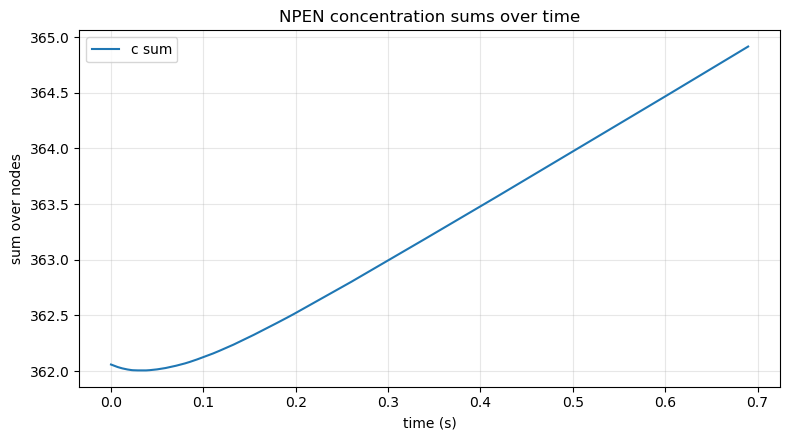

In [20]:
times, sums, fig, ax = plot_concentration_sums(filename, species=["c"])

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_concentration_change_norm_over_time(
    h5_path: str,
    species: tuple | None = None,
    norm: str = "l2",   # "l2" or "l1"
    include_points: bool = False
):
    """
    Plots the norm of the total amount of change in concentration per timestep over time.
    
    - Auto-selects reader by filename containing 'npen' (case-insensitive).
    - For each timestep t >= 1, computes Δ = concat_s [ vec( c_s(t) - c_s(t-1) ) ] over selected species s.
    - Norm options:
        "l2": sqrt(sum(Δ^2))  [default]
        "l1": sum(|Δ|)
    - Uses lazy reading (does not load full datasets into memory).

    Returns:
        times (np.ndarray): time axis aligned with t>=1 (size T-1)
        change_norm (np.ndarray): norm per timestep (size T-1)
        fig, ax
    """
    is_npen = "npen" in h5_path.lower()
    if is_npen:
        from pong_simulation.pong_sim_npen import PongH5Reader as Reader
        default_species = ("c",) if species is None else species
    else:
        from pong_simulation.pong_simulation import PongH5Reader as Reader
        default_species = ("c1", "c2", "c3") if species is None else species

    with Reader(h5_path) as rdr:
        # Filter to existing datasets for robustness
        valid_species = tuple(sp for sp in default_species if hasattr(rdr, sp))
        if not valid_species:
            raise ValueError(f"No requested species found in file. Requested: {default_species}")

        # Establish length and time axis (t=0..T-1 -> diffs at 1..T-1)
        T = getattr(rdr, valid_species[0]).shape[0]
        if T < 2:
            raise ValueError("Need at least 2 timesteps to compute per-timestep change.")
        dt = rdr.attrs.get("dt", None)
        times = (np.arange(1, T) * dt) if dt is not None else np.arange(1, T)

        # Prepare arrays
        change_norm = np.zeros(T - 1, dtype=np.float64)

        # Load t=0 baseline for all species lazily
        prev = {sp: np.array(getattr(rdr, sp)[0], dtype=np.float64) for sp in valid_species}

        # Iterate timesteps and compute norm of concatenated diffs
        for t in range(1, T):
            diffs = []
            for sp in valid_species:
                cur = np.array(getattr(rdr, sp)[t], dtype=np.float64)
                d = cur - prev[sp]
                if norm == "l1":
                    diffs.append(np.abs(d))
                else:  # l2 (default)
                    diffs.append(d)
                prev[sp] = cur  # advance baseline
            if norm == "l1":
                change_norm[t - 1] = float(np.nansum(np.concatenate(diffs)))
            else:
                vec = np.concatenate(diffs)
                change_norm[t - 1] = float(np.sqrt(np.nansum(vec * vec)))

    # Plot
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.plot(times, change_norm, label=f"||Δc||_{norm}", lw=2)
    if include_points:
        ax.scatter(times, change_norm, s=8, alpha=0.6)

    ax.set_xlabel("time (s)" if dt is not None else "timestep")
    ax.set_ylabel(f"norm of Δc per step ({norm})")
    ax.set_title(("NPEN" if is_npen else "NPP") + f" per-step concentration change norm ({norm})")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    return times, change_norm, fig, ax

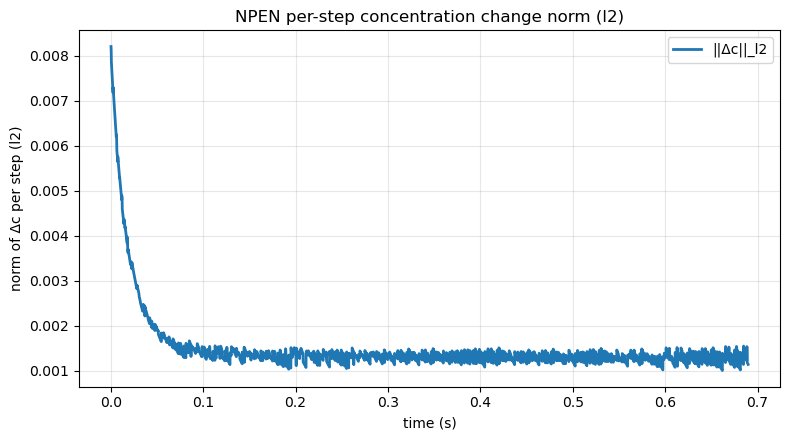

In [22]:
times, dnorm, fig, ax = plot_concentration_change_norm_over_time(
    filename
)

(1445, 3)